# **Sentiment Prediction**

In [1]:
import numpy as np
import pandas as pd
import platform
import configparser
from datetime import datetime, timedelta, date
import glob
import sys
import os
import timeit
from tqdm import tqdm

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import model_from_json

In [2]:
colab_active = 'google.colab' in sys.modules
print("Colab Active: ", colab_active)

Colab Active:  True


#**Downloads**

In [3]:
if colab_active is True:
  OS = platform.system()      # Operating System

  def data_download(file_to_download, gdrive_code, OS, uncompress = True):
    if not os.path.exists(file_to_download):
      os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
      if OS == "Linux" and uncompress:
          os.system('unzip -o -n "./'+file_to_download+'" -d '+os.path.dirname(file_to_download))
      return True
    else:
      return None

In [4]:
if colab_active is True:
  out = data_download("./Senntiment_Social_Mood_Corpus_Tweets.zip", "11lopgQpkQ-UjwP62icelthzISG_fn2_5", OS)
  out = data_download("./Sentiment_Social_Mood_Models.zip", "18WwKQxpjsftBl5tfdV62SZBqKxN1HOm5", OS)

## Configs

In [5]:
start_date: date = date(2020,1,1)
end_date  : date = date(2020,5,31)

small_df  : bool = False
small_size: int  = 200000

max_tokens: int  = 20000
k_model   : str  = 'mod_orig_onestep'

Create a list of dates ranging from `start_date` to `end_date`.

In [6]:
date_list = []

current_date = start_date
iteration = 1

while current_date <= end_date:
    date_list.append(f'{current_date.year}-{current_date.month:02d}-{current_date.day:02d}')
    current_date += timedelta(days=1)
    iteration += 1

<hr>

## Data

In [7]:
dfs = []

for date in date_list:
    df_date = pd.read_csv(f'./Senntiment_Social_Mood_Corpus_Tweets/corpus_tweets/{date}.csv', sep=';', encoding='ISO-8859-1')
    dfs.append(df_date)

In [8]:
raw_df = pd.concat(dfs, ignore_index=True)

if small_df is True:
    raw_df = raw_df.sample(small_size)

In [9]:
len(raw_df)

11980348

In [10]:
df = raw_df[['data_tweet', 'testo']]
df['data_tweet'] = pd.to_datetime(df['data_tweet'], format = '%Y%m%d')

<ipython-input-10-2b2346512ad4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['data_tweet'] = pd.to_datetime(df['data_tweet'], format = '%Y%m%d')


remove tweets that are not type: `str`.

In [11]:
df = df.loc[df['testo'].apply(lambda x: isinstance(x, str))]

## Pre-processing

In [12]:
tweets = np.array(df['testo'])

Transform words into tokens

In [15]:
tokenizer = Tokenizer(num_words = max_tokens)
tokenizer.fit_on_texts(tweets)

Transform word sequences into indexed token sequences

In [16]:
sequences = tokenizer.texts_to_sequences(tweets)

<hr>

## Import Model

In [17]:
#model = tf.keras.models.load_model(f'models/{k_model}')
#model = models.load_weights(f'sentiment_bilstm_best.hdf5')
json_file = open('./Sentiment_Social_Mood_Models/sentiment_bilstm_topology.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("./Sentiment_Social_Mood_Models/sentiment_bilstm_best.hdf5")

In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 300)         6248100   
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 256)        439296    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 64)         73984     
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                           

In [ ]:
test_tw = pad_sequences(tokenizer.texts_to_sequences(df['testo']), padding = "pre")

In [ ]:
len(test_tw)

## Predictions

In [ ]:
start_time = timeit.default_timer()
sentiment = model.predict(test_tw, batch_size = 2048, verbose = 1)
print("Prediction Elapsed Time: ", timeit.default_timer() - start_time)

In [ ]:
predicted_sentiment = [int(i > 0.5) for i in sentiment]
df['predicted_sentiment'] = predicted_sentiment

## Build the index

In [ ]:
df.set_index('data_tweet', inplace=True)

KeyError: ignored

In [ ]:
count_by_day = df.groupby([df.index.date, 'predicted_sentiment']).size()
count_by_day = count_by_day.reset_index()
count_by_day.rename(columns={0: 'count', 'level_0': 'date'}, inplace=True)
pivoted_counts = count_by_day.pivot(index='date', columns='predicted_sentiment', values='count')

In [ ]:
index = (pivoted_counts[1] - pivoted_counts[0]) / (pivoted_counts[1] + pivoted_counts[0])

Export results to csv.

In [ ]:
index.to_csv(f'predicted_{k_model}.csv', sep = ';', index=True)

## Plots

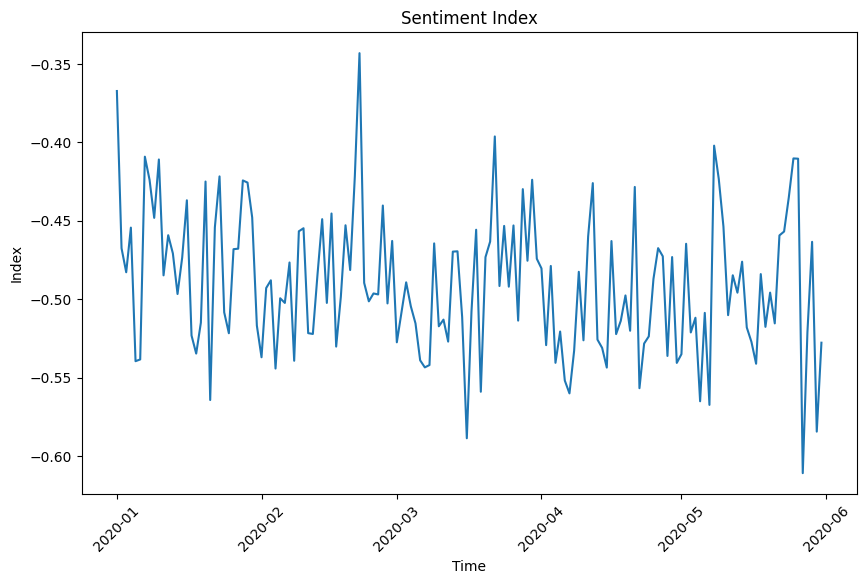

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(pivoted_counts.index, index)
ax.set_xlabel('Time')
ax.set_ylabel('Index')
ax.set_title('Sentiment Index')
plt.xticks(rotation=45)

plt.show()

## predictions_2020

In [ ]:
with open('predictions_2020.txt', 'r') as file:
    predictions_2020 = file.read()

predictions_2020 = predictions_2020.replace(' ', '').split(',')

In [ ]:
df['predicted_sentiment'] = predictions_2020[:-1]
df['predicted_sentiment'] = df['predicted_sentiment'].astype(int)

In [ ]:
df.set_index('data_tweet', inplace=True)

In [ ]:
count_by_day = df.groupby([df.index.date, 'predicted_sentiment']).size()
count_by_day = count_by_day.reset_index()
count_by_day.rename(columns={0: 'count', 'level_0': 'date'}, inplace=True)
pivoted_counts = count_by_day.pivot(index='date', columns='predicted_sentiment', values='count')

In [ ]:
index = (pivoted_counts[1] - pivoted_counts[0]) / (pivoted_counts[1] + pivoted_counts[0])

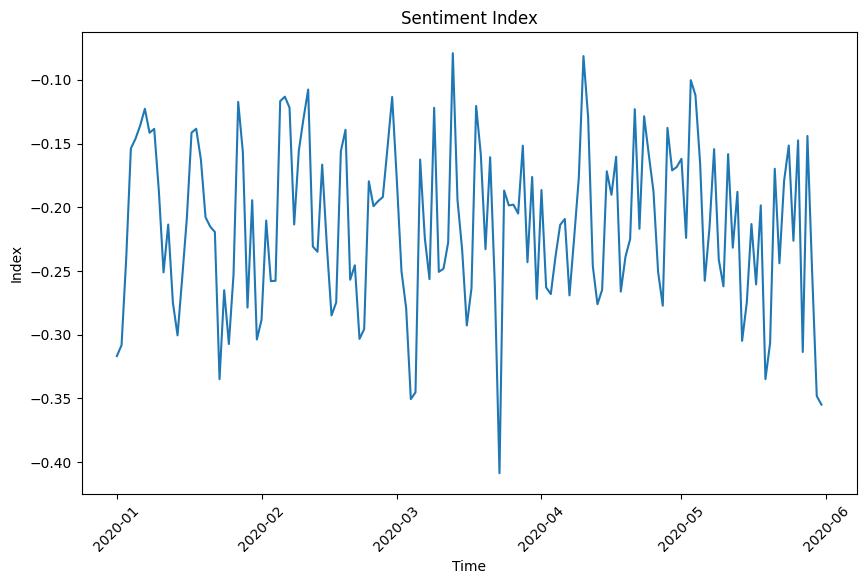

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(pivoted_counts.index, index)
ax.set_xlabel('Time')
ax.set_ylabel('Index')
ax.set_title('Sentiment Index')
plt.xticks(rotation=45)

plt.show()

In [ ]:
index.to_csv(f'predicted_2020.csv', sep = ';', index=True)